In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
#torch.multiprocessing.set_start_method("spawn")
import resnet 
from sklearn.model_selection import KFold

import os
import numpy as np
import pandas as pd
from utils import progress_bar
from skimage import transform as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
test = pd.read_json(BASE_dir + 'test.json')

ValueError: Could not reserve memory block

In [ ]:
len(train) # 1604 obs
train.head(3)
#randomly draw some of them

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,4)

index = np.random.choice(list(range(len(train))),size=8, replace=False)
for num,i in enumerate(index):
    for j in range(2):
        ax = plt.subplot(gs[num*2+j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Image index:%d, Band:%d' % (i, j%2+1))
        ax.set_aspect('equal')
        plt.imshow(np.array(train.iloc[i,j%2]).reshape(75,75))

In [3]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None, test=False): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
        self.test= test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            
            #rotate, scale, shear, translation
#             if self.test is False:
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 scale1 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 scale2 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 #shear = np.random.uniform(-np.pi/18, np.pi/18)
#                 #tran = np.random.uniform(-5, 5)
#                 #aug = tf.AffineTransform(shear = shear, translation=tran, scale= (scale1, scale2))
#                 aug = tf.AffineTransform(scale= (scale1, scale2))
#                 img = tf.warp(img, inverse_map=aug)
            
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
            
            if self.test is False:
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=1).copy()
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=2).copy()
                rotate = np.random.randint(4, size=1)
                #scale = np.exp(np.random.uniform(np.log(1/1.1), np.log(1.1)))
                #aug = tf.AffineTransform(scale= (scale, scale))
                #img = tf.warp(img, inverse_map=aug)
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
                if rotate:
                    img = np.rot90(img,k=rotate,axes=(1,2)).copy()
            img = torch.from_numpy(img).type(dtype)
            img = self.transform(img)

        return img, label

def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
#     data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

def data_aug(X, y):
    
    X_rot_30 = []
    X_rot_60 = [] 
    X_h = np.flip(X, 3)
    X_v = np.flip(X, 2)
    for i in X:
        X_rot_30.append(tf.rotate(i,angle=30,resize=False))
        X_rot_60.append(tf.rotate(i,angle=60,resize=False))
        
    X_rot_30 = np.stack(X_rot_30)
    X_rot_60 = np.stack(X_rot_60)
    ch_y = np.concatenate((y,y,y,y,y))
    ch_X = np.concatenate((X, X_h, X_v, X_rot_30, X_rot_60))
    return ch_X, ch_y


train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [45]:
# train_index=list(range(1300))
# val_index= list(range(1300,1604))
train_index=list(range(304,1604)) 
val_index= list(range(304))
# train_X[train_index].shape

# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))
train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

## add augmentation 
# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))

# train_X_af,train_y_af = data_aug(train_X[train_index], train_y[train_index])
# train_mean, train_std = transform_compute(train_X_af)
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(data= train_X_af, label=train_y_af, transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

In [6]:
torch.cuda.is_available()
torch.from_numpy(train_X).type(torch.FloatTensor)[1].shape
train_X[1]
use_cuda

True

In [82]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >=best_acc:
                best_acc= acc
                e_s = 0
                torch.save(net.state_dict(), 'resnet34_acc.pth')
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_acc,i

    return best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

In [83]:
resnet34 = resnet.resnet34(num_classes=2)
net= resnet34

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here   
#(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0000, nesterov= True)
#scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience =20,min_lr= 0.0001)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=200)


This is epoch:1
[=================== 41/41 =================>.]  Step: 64ms | Tot: 3s251ms | Loss: 2.027 | Acc: 59.923% (779/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 170ms | Loss: 0.841 | Acc: 50.658% (154/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 64ms | Tot: 3s239ms | Loss: 1.674 | Acc: 57.077% (742/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 170ms | Loss: 6.344 | Acc: 59.868% (182/304)

This is epoch:3
[=================== 41/41 =================>.]  Step: 64ms | Tot: 3s245ms | Loss: 0.748 | Acc: 57.538% (748/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 171ms | Loss: 0.665 | Acc: 47.697% (145/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 64ms | Tot: 3s236ms | Loss: 0.961 | Acc: 57.462% (747/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 169ms | Loss: 0.599 | Acc: 66.118% (201/304)

This is epoch:5
[======

[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s255ms | Loss: 0.233 | Acc: 90.231% (1173/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 170ms | Loss: 0.235 | Acc: 90.132% (274/304)

This is epoch:68
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s250ms | Loss: 0.237 | Acc: 89.846% (1168/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 169ms | Loss: 0.216 | Acc: 90.461% (275/304)

This is epoch:69
[=================== 41/41 =================>.]  Step: 64ms | Tot: 3s253ms | Loss: 0.223 | Acc: 90.000% (1170/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 169ms | Loss: 0.224 | Acc: 91.447% (278/304)

This is epoch:70
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s247ms | Loss: 0.232 | Acc: 90.231% (1173/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 171ms | Loss: 0.189 | Acc: 92.105% (280/304)

This is epoch:71
[===============

[=================== 41/41 =================>.]  Step: 64ms | Tot: 3s240ms | Loss: 0.154 | Acc: 93.769% (1219/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 170ms | Loss: 0.208 | Acc: 92.105% (280/304)

This is epoch:134
[=================== 41/41 =================>.]  Step: 64ms | Tot: 3s249ms | Loss: 0.151 | Acc: 94.000% (1222/1300)
[=================== 5/5 ============>........]  Step: 35ms | Tot: 170ms | Loss: 0.205 | Acc: 92.434% (281/304)

This is epoch:135
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s252ms | Loss: 0.150 | Acc: 93.538% (1216/1300)
[=================== 5/5 ============>........]  Step: 34ms | Tot: 168ms | Loss: 0.204 | Acc: 91.776% (279/304)

This is epoch:136
[=================== 41/41 =================>.]  Step: 64ms | Tot: 3s250ms | Loss: 0.143 | Acc: 94.385% (1227/1300)
[=================== 5/5 ============>........]  Step: 36ms | Tot: 172ms | Loss: 0.206 | Acc: 91.776% (279/304)

This is epoch:137
[===========

Process Process-5339:
Process Process-5340:
Process Process-5338:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    r

In [76]:
##For continue training
resnet34 = resnet.resnet34(num_classes=2)
net= resnet34
net.load_state_dict(torch.load('save_resnet34_acc.pth'))

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00012, nesterov= True)
scheduler = MultiStepLR(optimizer, [50,100], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

#train(epoch=150)


test_set = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test_set)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)
result = []
for i in range(10):
    train(epoch=1)

    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    result.append(np.concatenate(prob))


This is epoch:1
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s272ms | Loss: 0.175 | Acc: 92.538% (1203/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 171ms | Loss: 0.194 | Acc: 93.092% (283/304)
[=================== 132/132 ================>]  Step: 33ms | Tot: 5s848ms

This is epoch:1
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s282ms | Loss: 0.169 | Acc: 92.846% (1207/1300)
[=================== 5/5 ============>........]  Step: 34ms | Tot: 168ms | Loss: 0.195 | Acc: 92.434% (281/304)
[=================== 132/132 ================>]  Step: 32ms | Tot: 5s827ms

This is epoch:1
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s279ms | Loss: 0.176 | Acc: 92.154% (1198/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 170ms | Loss: 0.194 | Acc: 92.763% (282/304)
[=================== 132/132 ================>]  Step: 33ms | Tot: 5s807ms

This is epoch:1
[=================== 41

In [75]:
test_set = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test_set)
test_X.shape

(8424, 3, 75, 75)

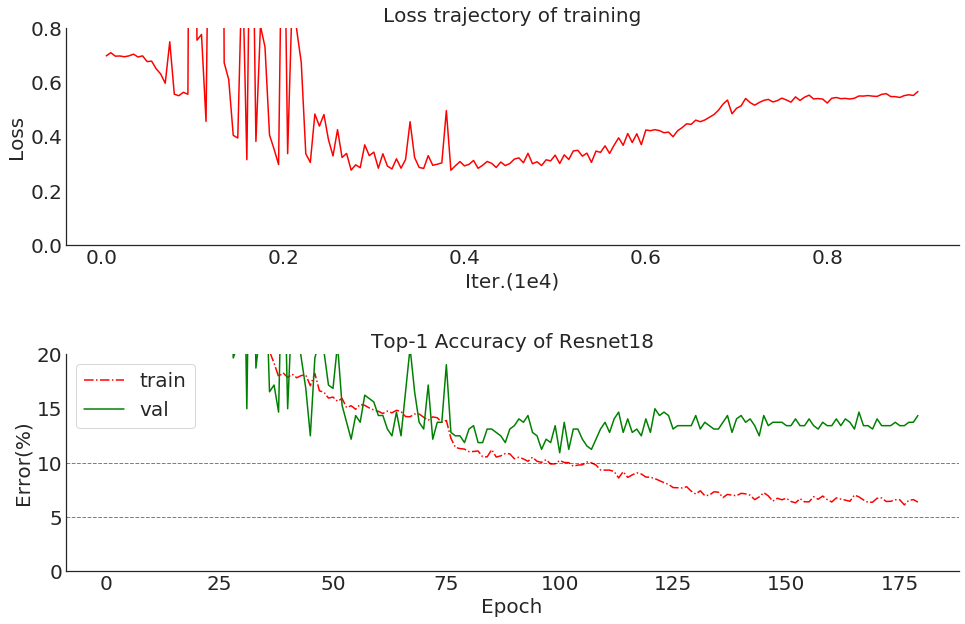

In [38]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.8))

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet34',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

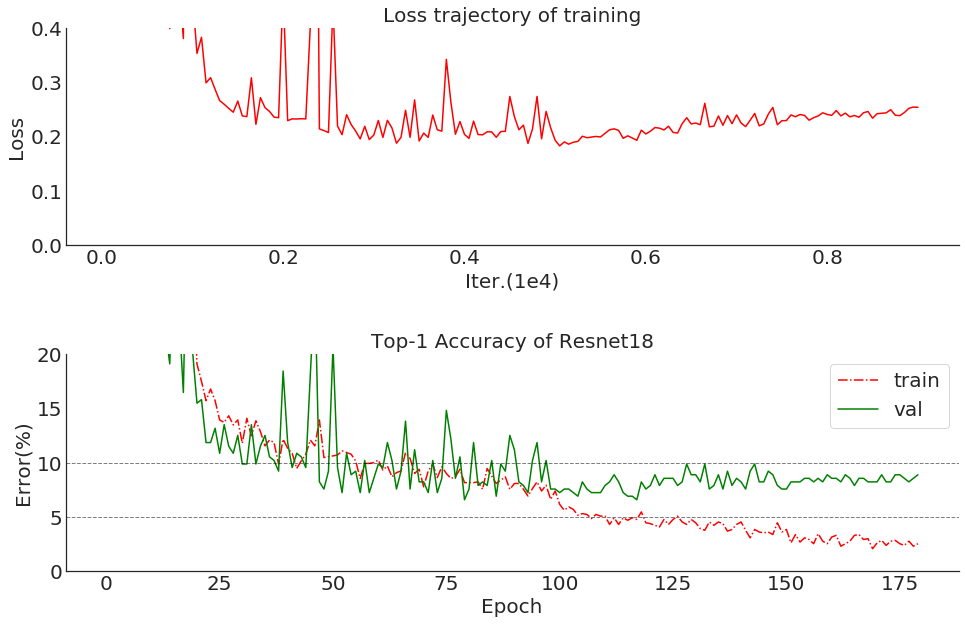

In [28]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.4))

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet18',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

In [19]:
#Bayesian optimization

from bayes_opt import BayesianOptimization

opt_hist=[]
def resnet_evaluate(lr,wd):
    global net,criterion, optimizer,scheduler
    
    net = resnet.resnet18(num_classes=2)

    criterion = nn.CrossEntropyLoss()

    #Adam does not perform so good here
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd, nesterov= True)
    scheduler = MultiStepLR(optimizer, [30,60,90], gamma=0.1)
    #5e-3 86
    if use_cuda:
        criterion.cuda()
        net.cuda()
    result = train(epoch=120,early_stopping=25)
    opt_hist.append(result)
    return result[0]

resnetOB = BayesianOptimization(resnet_evaluate, {'lr': (0.0001, 0.1),
                                                   'wd':(0.0001, 0.1)
                                                 })

resnetOB.explore({
'lr': (0.1, 0.01,0.001,0.1, 0.01,0.001),
'wd':(0.0001, 0.0001,0.0001,0.001,0.002,0.003)
})



resnetOB.maximize(init_points=3, n_iter=10,acq='ei', xi=0.05)

Initialization
-----------------------------------------------------
 Step |   Time |      Value |        lr |        wd | 

This is epoch:1
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s44ms | Loss: 3.181 | Acc: 57.462% (747/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 45.076 | Acc: 35.526% (108/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s15ms | Loss: 0.792 | Acc: 61.154% (795/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.824 | Acc: 46.711% (142/304)

This is epoch:3
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s27ms | Loss: 0.662 | Acc: 64.385% (837/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 632ms | Loss: 0.670 | Acc: 55.592% (169/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s4ms | Loss: 0.744 | Acc: 62.923% (818/1300)0)


[=================== 5/5 ============>........]  Step: 143ms | Tot: 633ms | Loss: 0.297 | Acc: 86.842% (264/304)

This is epoch:66
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s29ms | Loss: 0.237 | Acc: 90.538% (1177/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.307 | Acc: 85.526% (260/304)

This is epoch:67
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s26ms | Loss: 0.243 | Acc: 90.154% (1172/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.318 | Acc: 84.539% (257/304)

This is epoch:68
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s20ms | Loss: 0.249 | Acc: 89.385% (1162/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.299 | Acc: 86.184% (262/304)

This is epoch:69
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s33ms | Loss: 0.245 | Acc: 90.615% (1178/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.250 | Acc: 88.158% (268/304)

This is epoch:20
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s45ms | Loss: 0.184 | Acc: 93.077% (1210/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 630ms | Loss: 0.394 | Acc: 82.566% (251/304)

This is epoch:21
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.209 | Acc: 91.154% (1185/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.571 | Acc: 76.316% (232/304)

This is epoch:22
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.208 | Acc: 91.692% (1192/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.444 | Acc: 83.224% (253/304)

This is epoch:23
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s41ms | Loss: 0.191 | Acc: 92.077% (1197/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.300 | Acc: 86.184% (262/304)

This is epoch:31
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s45ms | Loss: 0.178 | Acc: 93.462% (1215/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.346 | Acc: 84.539% (257/304)

This is epoch:32
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s41ms | Loss: 0.182 | Acc: 92.923% (1208/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.317 | Acc: 87.171% (265/304)

This is epoch:33
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.177 | Acc: 93.154% (1211/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.332 | Acc: 84.868% (258/304)

This is epoch:34
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s25ms | Loss: 0.175 | Acc: 93.462% (1215/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.258 | Acc: 90.461% (275/304)

This is epoch:42
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s47ms | Loss: 0.213 | Acc: 91.077% (1184/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.246 | Acc: 91.118% (277/304)

This is epoch:43
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s52ms | Loss: 0.209 | Acc: 91.000% (1183/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 639ms | Loss: 0.269 | Acc: 88.816% (270/304)

This is epoch:44
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s37ms | Loss: 0.211 | Acc: 91.769% (1193/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.287 | Acc: 87.171% (265/304)

This is epoch:45
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.200 | Acc: 92.000% (1196/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.589 | Acc: 63.816% (194/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s46ms | Loss: 0.443 | Acc: 79.923% (1039/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.496 | Acc: 71.053% (216/304)

This is epoch:5
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s38ms | Loss: 0.426 | Acc: 80.462% (1046/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.473 | Acc: 74.342% (226/304)

This is epoch:6
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.389 | Acc: 83.077% (1080/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.485 | Acc: 72.697% (221/304)

This is epoch:7
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.376 | Acc: 83.385% (1084/1300))
[=======

[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.708 | Acc: 33.553% (102/304)

This is epoch:18
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s18ms | Loss: 0.694 | Acc: 52.385% (681/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.740 | Acc: 33.553% (102/304)

This is epoch:19
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s12ms | Loss: 0.698 | Acc: 48.846% (635/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 633ms | Loss: 0.683 | Acc: 66.447% (202/304)

This is epoch:20
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s11ms | Loss: 0.695 | Acc: 50.231% (653/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.687 | Acc: 66.447% (202/304)

This is epoch:21
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s26ms | Loss: 0.696 | Acc: 51.308% (667/1300))
[=======

[=================== 41/41 =================>.]  Step: 427ms | Tot: 14s989ms | Loss: 0.397 | Acc: 83.615% (1087/1300)
[=================== 5/5 ============>........]  Step: 145ms | Tot: 639ms | Loss: 0.783 | Acc: 56.908% (173/304)

This is epoch:51
[=================== 41/41 =================>.]  Step: 427ms | Tot: 14s989ms | Loss: 0.388 | Acc: 82.923% (1078/1300)
[=================== 5/5 ============>........]  Step: 145ms | Tot: 636ms | Loss: 0.495 | Acc: 77.303% (235/304)

This is epoch:52
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s9ms | Loss: 0.409 | Acc: 82.308% (1070/1300)0)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.507 | Acc: 75.658% (230/304)

This is epoch:53
[=================== 41/41 =================>.]  Step: 429ms | Tot: 14s987ms | Loss: 0.383 | Acc: 84.385% (1097/1300)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.511 | Acc: 74.013% (225/304)

This is epoch:54
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s33ms | Loss: 0.264 | Acc: 90.077% (1171/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 633ms | Loss: 0.335 | Acc: 85.526% (260/304)

This is epoch:43
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s45ms | Loss: 0.279 | Acc: 89.385% (1162/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.279 | Acc: 89.803% (273/304)

This is epoch:44
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s33ms | Loss: 0.268 | Acc: 89.923% (1169/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.369 | Acc: 83.882% (255/304)

This is epoch:45
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s53ms | Loss: 0.264 | Acc: 90.385% (1175/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.515 | Acc: 75.987% (231/304)

This is epoch:46
[===

[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.559 | Acc: 66.447% (202/304)

This is epoch:30
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s24ms | Loss: 0.439 | Acc: 80.692% (1049/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.826 | Acc: 51.316% (156/304)

This is epoch:31
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s16ms | Loss: 0.441 | Acc: 80.077% (1041/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 633ms | Loss: 0.592 | Acc: 66.776% (203/304)

This is epoch:32
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s10ms | Loss: 0.399 | Acc: 83.308% (1083/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.469 | Acc: 74.671% (227/304)

This is epoch:33
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s27ms | Loss: 0.370 | Acc: 84.615% (1100/1300))
[===

[=================== 5/5 ============>........]  Step: 145ms | Tot: 631ms | Loss: 0.261 | Acc: 89.803% (273/304)

This is epoch:95
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s13ms | Loss: 0.198 | Acc: 92.308% (1200/1300))
[=================== 5/5 ============>........]  Step: 148ms | Tot: 641ms | Loss: 0.270 | Acc: 89.803% (273/304)

This is epoch:96
[=================== 41/41 =================>.]  Step: 427ms | Tot: 14s997ms | Loss: 0.189 | Acc: 92.923% (1208/1300)
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.292 | Acc: 88.487% (269/304)

This is epoch:97
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s12ms | Loss: 0.205 | Acc: 92.462% (1202/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.283 | Acc: 88.487% (269/304)

This is epoch:98
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s11ms | Loss: 0.203 | Acc: 92.000% (1196/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 632ms | Loss: 0.715 | Acc: 46.382% (141/304)

This is epoch:5
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s37ms | Loss: 0.541 | Acc: 71.615% (931/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 630ms | Loss: 0.784 | Acc: 54.276% (165/304)

This is epoch:6
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s27ms | Loss: 0.524 | Acc: 73.385% (954/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.737 | Acc: 44.079% (134/304)

This is epoch:7
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s32ms | Loss: 0.471 | Acc: 77.769% (1011/1300)
[=================== 5/5 ============>........]  Step: 147ms | Tot: 638ms | Loss: 0.843 | Acc: 40.461% (123/304)

This is epoch:8
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.462 | Acc: 79.000% (1027/1300))
[==========

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.287 | Acc: 87.500% (266/304)

This is epoch:70
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s41ms | Loss: 0.175 | Acc: 93.154% (1211/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.284 | Acc: 87.829% (267/304)

This is epoch:71
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.184 | Acc: 92.692% (1205/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.290 | Acc: 87.500% (266/304)
   12 | 19m43s |   89.80263 |    0.0992 |    0.0027 | 

This is epoch:1
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s29ms | Loss: 1.412 | Acc: 64.846% (843/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.848 | Acc: 47.368% (144/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.292 | Acc: 88.487% (269/304)

This is epoch:64
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s55ms | Loss: 0.176 | Acc: 93.308% (1213/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.287 | Acc: 86.842% (264/304)

This is epoch:65
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s34ms | Loss: 0.171 | Acc: 93.846% (1220/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 631ms | Loss: 0.272 | Acc: 88.158% (268/304)

This is epoch:66
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s18ms | Loss: 0.160 | Acc: 93.692% (1218/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.271 | Acc: 88.158% (268/304)

This is epoch:67
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s16ms | Loss: 0.169 | Acc: 93.231% (1212/1300))
[===

[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s10ms | Loss: 0.336 | Acc: 83.846% (1090/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.675 | Acc: 69.408% (211/304)

This is epoch:48
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s4ms | Loss: 0.329 | Acc: 84.154% (1094/1300)0)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.321 | Acc: 86.842% (264/304)

This is epoch:49
[=================== 41/41 =================>.]  Step: 428ms | Tot: 14s998ms | Loss: 0.338 | Acc: 84.308% (1096/1300)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.352 | Acc: 84.868% (258/304)

This is epoch:50
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s10ms | Loss: 0.301 | Acc: 87.231% (1134/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 633ms | Loss: 0.321 | Acc: 85.197% (259/304)

This is epoch:51
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s38ms | Loss: 0.219 | Acc: 90.846% (1181/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.668 | Acc: 68.421% (208/304)

This is epoch:22
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.221 | Acc: 91.538% (1190/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.249 | Acc: 91.118% (277/304)

This is epoch:23
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.193 | Acc: 92.769% (1206/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.301 | Acc: 86.513% (263/304)

This is epoch:24
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s32ms | Loss: 0.225 | Acc: 91.154% (1185/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 636ms | Loss: 0.363 | Acc: 85.855% (261/304)

This is epoch:25
[===

[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s38ms | Loss: 0.072 | Acc: 97.846% (1272/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.345 | Acc: 86.842% (264/304)

This is epoch:40
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s35ms | Loss: 0.092 | Acc: 96.308% (1252/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.359 | Acc: 86.842% (264/304)

This is epoch:41
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s40ms | Loss: 0.079 | Acc: 97.000% (1261/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.309 | Acc: 89.145% (271/304)

This is epoch:42
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.074 | Acc: 97.615% (1269/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.363 | Acc: 88.158% (268/304)

This is epoch:43
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s46ms | Loss: 0.179 | Acc: 91.923% (1195/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.271 | Acc: 90.461% (275/304)

This is epoch:27
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s58ms | Loss: 0.186 | Acc: 92.000% (1196/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.416 | Acc: 84.868% (258/304)

This is epoch:28
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s48ms | Loss: 0.178 | Acc: 93.385% (1214/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 638ms | Loss: 0.374 | Acc: 84.539% (257/304)

This is epoch:29
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s63ms | Loss: 0.196 | Acc: 91.077% (1184/1300))
[=================== 5/5 ============>........]  Step: 146ms | Tot: 638ms | Loss: 0.718 | Acc: 73.355% (223/304)

This is epoch:30
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s28ms | Loss: 0.065 | Acc: 97.615% (1269/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.346 | Acc: 86.842% (264/304)

This is epoch:43
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s35ms | Loss: 0.064 | Acc: 98.000% (1274/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.354 | Acc: 86.842% (264/304)

This is epoch:44
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s45ms | Loss: 0.086 | Acc: 97.462% (1267/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.334 | Acc: 88.487% (269/304)

This is epoch:45
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s48ms | Loss: 0.063 | Acc: 97.846% (1272/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.384 | Acc: 85.855% (261/304)

This is epoch:46
[===

In [18]:
out1 = torch.cat((out.data,out.data),1)
out1.size()
# out
criterion(out,y.long())
type(predicted)
type(y.data)
#predicted.eq(y.data).cpu().sum()

torch.cuda.DoubleTensor

In [79]:
net = resnet.resnet34(num_classes=2)
net.load_state_dict(torch.load('save_resnet34_acc.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

[=================== 132/132 ================>]  Step: 33ms | Tot: 5s834ms


In [77]:
k =np.stack(result).mean(axis=0)
# #sub.shape
# result[1].shape
# np.concatenate(prob).shape

In [80]:
sub=pd.DataFrame()
sub['id'] = test_set['id']
sub['is_iceberg'] =  np.concatenate(prob)
sub.shape
sub.to_csv('submission2.csv',index=False)

In [41]:
temp= pd.read_csv('submission3.csv') #0.0001 wd one
sub['is_iceberg2'] = temp['is_iceberg']
sub.corr()

,is_iceberg,is_iceberg2
is_iceberg,1.000000,0.886197
is_iceberg2,0.886197,1.000000


In [11]:
#try dropout 0.5 on the last fc
resnet34 = resnet.resnet34(num_classes=2)
net= resnet34

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here   
#(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov= True)
scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=250)


This is epoch:1
[=================== 41/41 =================>.]  Step: 460ms | Tot: 16s242ms | Loss: 4.618 | Acc: 56.231% (731/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 770ms | Loss: 421.466 | Acc: 50.658% (154/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 464ms | Tot: 16s191ms | Loss: 2.397 | Acc: 59.308% (771/1300)
[=================== 5/5 ============>........]  Step: 174ms | Tot: 767ms | Loss: 1032.273 | Acc: 49.342% (150/304)

This is epoch:3
[=================== 41/41 =================>.]  Step: 463ms | Tot: 16s228ms | Loss: 1.995 | Acc: 58.154% (756/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 766ms | Loss: 522.733 | Acc: 59.539% (181/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 469ms | Tot: 16s205ms | Loss: 5.970 | Acc: 52.615% (684/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 9.002 | Acc: 50.000% (152/304)

This

[=================== 5/5 ============>........]  Step: 173ms | Tot: 769ms | Loss: 1.166 | Acc: 54.605% (166/304)

This is epoch:66
[=================== 41/41 =================>.]  Step: 463ms | Tot: 16s185ms | Loss: 0.602 | Acc: 65.538% (852/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 837ms | Loss: 0.596 | Acc: 69.079% (210/304)

This is epoch:67
[=================== 41/41 =================>.]  Step: 463ms | Tot: 16s185ms | Loss: 0.594 | Acc: 64.769% (842/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 772ms | Loss: 0.633 | Acc: 63.487% (193/304)

This is epoch:68
[=================== 41/41 =================>.]  Step: 461ms | Tot: 16s184ms | Loss: 0.610 | Acc: 63.308% (823/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 769ms | Loss: 0.650 | Acc: 68.421% (208/304)

This is epoch:69
[=================== 41/41 =================>.]  Step: 466ms | Tot: 16s189ms | Loss: 0.606 | Acc: 65.077% (846/1300)
[=======

[=================== 5/5 ============>........]  Step: 172ms | Tot: 775ms | Loss: 0.245 | Acc: 89.474% (272/304)  Step: 200ms | Tot: 400ms | Loss: 0.246 | Acc: 88.021% (169/192)

This is epoch:129
[=================== 41/41 =================>.]  Step: 464ms | Tot: 16s203ms | Loss: 0.266 | Acc: 87.154% (1133/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.238 | Acc: 91.447% (278/304)  Step: 200ms | Tot: 596ms | Loss: 0.224 | Acc: 91.797% (235/256)

This is epoch:130
[=================== 41/41 =================>.]  Step: 462ms | Tot: 16s211ms | Loss: 0.272 | Acc: 87.923% (1143/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 769ms | Loss: 0.230 | Acc: 90.461% (275/304)

This is epoch:131
[=================== 41/41 =================>.]  Step: 461ms | Tot: 16s205ms | Loss: 0.252 | Acc: 88.000% (1144/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 775ms | Loss: 0.231 | Acc: 90.789% (276/304)

This i

[=================== 41/41 =================>.]  Step: 461ms | Tot: 16s195ms | Loss: 0.239 | Acc: 89.385% (1162/1300)
[=================== 5/5 ============>........]  Step: 171ms | Tot: 769ms | Loss: 0.215 | Acc: 91.776% (279/304)

This is epoch:193
[=================== 41/41 =================>.]  Step: 462ms | Tot: 16s206ms | Loss: 0.239 | Acc: 89.846% (1168/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.214 | Acc: 92.434% (281/304)

This is epoch:194
[=================== 41/41 =================>.]  Step: 460ms | Tot: 16s207ms | Loss: 0.230 | Acc: 90.231% (1173/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.215 | Acc: 91.447% (278/304)

This is epoch:195
[=================== 41/41 =================>.]  Step: 458ms | Tot: 16s180ms | Loss: 0.230 | Acc: 90.385% (1175/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.216 | Acc: 91.447% (278/304)

This is epoch:196


(93.42105263157895, 249)

In [9]:
def train(epoch,early_stopping = None):
    global train_data, lr#,out,y,predicted
    best_acc =0
    val_loss =0
    acc= 0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        scheduler.step(acc)
        #scheduler.step()
        if lr != optimizer.param_groups[0]['lr']:
            print('We change learning rate from %f to %f '%(lr, optimizer.param_groups[0]['lr']))
            lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >=best_acc:
                best_acc= acc
                e_s = 0
                torch.save(net.state_dict(), 'resnet34_acc.pth')
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_acc,i

    return best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total


#Try different transformation

result_hist=[]
for rou in range(10):
    ran_num = np.random.randint(10000,size=1)
    seed= np.random.RandomState(ran_num)
    spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
    for k,(train_index, val_index) in enumerate(spliter.split(train_X)):
        train_X[train_index].shape

        train_mean, train_std = transform_compute(train_X[train_index])
        train_transform = T.Compose([
            T.Normalize(train_mean, train_std)
        ])

        train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
        val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

        train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                                  shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

        resnet34 = resnet.resnet34(num_classes=2)
        net= resnet34

        criterion = nn.CrossEntropyLoss()

        #Adam does not perform so good here   
        #(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
        optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.00008, nesterov= True)
        #scheduler = MultiStepLR(optimizer, [110,160,200], gamma=0.1)

        #
        scheduler = ReduceLROnPlateau(optimizer, 'max', patience =20)
        #5e-3 86
        if use_cuda:
            criterion.cuda()
            net.cuda()
        #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
        #     cudnn.benchmark = True   

        result = train(epoch=300,early_stopping=25)
        result_hist.append(result)
        if result[0] >=92 or (rou ==0 and k==0):
            with open("log.txt", "a") as myfile:
                msg = 'At round {}, fold {}, seed {}, we find a good value with acc:, and train with {} epoch\n'.format(rou,
                                                            k,ran_num, result[0] )
                myfile.write(msg)
            cmd = 'cp resnet34_acc.pth resnet34_save_model/resnet34_acc{}{}.pth'.format(rou,k)
            os.system(cmd)


This is epoch:1
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s839ms | Loss: 4.738 | Acc: 52.689% (676/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 21.001 | Acc: 54.206% (174/321)) Step: 200ms | Tot: 390ms | Loss: 27.292 | Acc: 49.479% (95/192)

This is epoch:2
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s800ms | Loss: 1.305 | Acc: 53.313% (684/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 800ms | Loss: 3.006 | Acc: 54.829% (176/321))

This is epoch:3
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s791ms | Loss: 0.891 | Acc: 50.195% (644/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 804ms | Loss: 2.862 | Acc: 51.090% (164/321))

This is epoch:4
[=================== 41/41 =================>.]  Step: 183ms | Tot: 15s809ms | Loss: 0.747 | Acc: 50.039% (642/1283)
[=================== 6/6 =============>.......]  Step: 15ms 

[=================== 41/41 =================>.]  Step: 180ms | Tot: 15s745ms | Loss: 0.623 | Acc: 63.445% (814/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 808ms | Loss: 0.597 | Acc: 68.224% (219/321))

This is epoch:65
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s755ms | Loss: 0.631 | Acc: 61.419% (788/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 796ms | Loss: 0.610 | Acc: 68.536% (220/321))

This is epoch:66
[=================== 41/41 =================>.]  Step: 181ms | Tot: 15s757ms | Loss: 0.632 | Acc: 63.757% (818/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 810ms | Loss: 0.589 | Acc: 68.847% (221/321))

This is epoch:67
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s754ms | Loss: 0.619 | Acc: 64.458% (827/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 800ms | Loss: 0.589 | Acc: 67.913% (218/321))

This is epoch:68
[=======

[=================== 6/6 =============>.......]  Step: 15ms | Tot: 800ms | Loss: 0.545 | Acc: 73.209% (235/321))

This is epoch:129
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s768ms | Loss: 0.557 | Acc: 70.772% (908/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 0.533 | Acc: 72.586% (233/321))

This is epoch:130
[=================== 41/41 =================>.]  Step: 182ms | Tot: 15s752ms | Loss: 0.556 | Acc: 69.836% (896/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 800ms | Loss: 0.537 | Acc: 73.832% (237/321))

This is epoch:131
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s757ms | Loss: 0.566 | Acc: 69.836% (896/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 803ms | Loss: 0.540 | Acc: 70.405% (226/321))

This is epoch:132
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s787ms | Loss: 0.561 | Acc: 70.226% (901/1283)
[===

[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s799ms | Loss: 0.576 | Acc: 68.433% (878/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 800ms | Loss: 0.550 | Acc: 71.651% (230/321))

This is epoch:13
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s797ms | Loss: 0.589 | Acc: 67.498% (866/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 807ms | Loss: 0.626 | Acc: 65.109% (209/321))

This is epoch:14
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s795ms | Loss: 0.541 | Acc: 70.226% (901/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 808ms | Loss: 0.504 | Acc: 74.766% (240/321))

This is epoch:15
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s799ms | Loss: 0.489 | Acc: 75.448% (968/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 808ms | Loss: 0.532 | Acc: 72.274% (232/321))

This is epoch:16
[=======

[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s877ms | Loss: 0.359 | Acc: 84.489% (1084/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 805ms | Loss: 0.423 | Acc: 80.685% (259/321))

This is epoch:76
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s846ms | Loss: 0.367 | Acc: 83.944% (1077/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 803ms | Loss: 0.475 | Acc: 78.505% (252/321))

This is epoch:77
[=================== 41/41 =================>.]  Step: 181ms | Tot: 15s835ms | Loss: 0.332 | Acc: 86.126% (1105/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 809ms | Loss: 0.352 | Acc: 87.850% (282/321))

This is epoch:78
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s851ms | Loss: 0.314 | Acc: 85.269% (1094/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 813ms | Loss: 0.313 | Acc: 87.227% (280/321))

This is epoch:79
[===

[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s856ms | Loss: 0.184 | Acc: 92.518% (1187/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 0.261 | Acc: 91.589% (294/321))

This is epoch:139
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s811ms | Loss: 0.183 | Acc: 92.751% (1190/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 812ms | Loss: 0.247 | Acc: 90.343% (290/321))

This is epoch:140
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s853ms | Loss: 0.180 | Acc: 91.894% (1179/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 809ms | Loss: 0.248 | Acc: 91.277% (293/321))

This is epoch:141
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s809ms | Loss: 0.178 | Acc: 92.751% (1190/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 0.251 | Acc: 90.966% (292/321))

This is epoch:142


[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s738ms | Loss: 0.392 | Acc: 83.242% (1068/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 799ms | Loss: 0.388 | Acc: 83.178% (267/321))

This is epoch:54
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s759ms | Loss: 0.380 | Acc: 84.412% (1083/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 794ms | Loss: 0.389 | Acc: 82.243% (264/321))

This is epoch:55
[=================== 41/41 =================>.]  Step: 183ms | Tot: 15s758ms | Loss: 0.364 | Acc: 85.269% (1094/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 800ms | Loss: 0.363 | Acc: 85.358% (274/321))

This is epoch:56
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s744ms | Loss: 0.389 | Acc: 84.723% (1087/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 802ms | Loss: 0.338 | Acc: 85.358% (274/321))

This is epoch:57
[===

[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s778ms | Loss: 0.648 | Acc: 59.002% (757/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 800ms | Loss: 0.648 | Acc: 61.371% (197/321))  Step: 200ms | Tot: 590ms | Loss: 0.647 | Acc: 65.234% (167/256)

This is epoch:7
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s775ms | Loss: 0.634 | Acc: 61.263% (786/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 797ms | Loss: 0.626 | Acc: 62.617% (201/321))

This is epoch:8
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s775ms | Loss: 0.631 | Acc: 59.704% (766/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 804ms | Loss: 1.077 | Acc: 53.271% (171/321))

This is epoch:9
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s785ms | Loss: 0.665 | Acc: 62.120% (797/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 797ms | Lo

[=================== 6/6 =============>.......]  Step: 16ms | Tot: 807ms | Loss: 0.347 | Acc: 85.670% (275/321))

This is epoch:69
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s856ms | Loss: 0.333 | Acc: 85.035% (1091/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 809ms | Loss: 0.383 | Acc: 83.801% (269/321))  Step: 200ms | Tot: 391ms | Loss: 0.372 | Acc: 83.854% (161/192)

This is epoch:70
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s838ms | Loss: 0.322 | Acc: 86.282% (1107/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 802ms | Loss: 0.286 | Acc: 87.539% (281/321))

This is epoch:71
[=================== 41/41 =================>.]  Step: 181ms | Tot: 15s826ms | Loss: 0.323 | Acc: 85.269% (1094/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 803ms | Loss: 0.308 | Acc: 85.670% (275/321))  Step: 199ms | Tot: 590ms | Loss: 0.305 | Acc: 86.328% (221/256)

This is e

[=================== 6/6 =============>.......]  Step: 16ms | Tot: 808ms | Loss: 0.219 | Acc: 91.277% (293/321))

This is epoch:132
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s793ms | Loss: 0.222 | Acc: 91.504% (1174/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 808ms | Loss: 0.210 | Acc: 92.523% (297/321))

This is epoch:133
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s825ms | Loss: 0.222 | Acc: 91.348% (1172/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 0.217 | Acc: 90.654% (291/321))

This is epoch:134
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s797ms | Loss: 0.228 | Acc: 90.881% (1166/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 809ms | Loss: 0.215 | Acc: 91.277% (293/321))

This is epoch:135
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s837ms | Loss: 0.221 | Acc: 91.660% (1176/1283)


[=================== 41/41 =================>.]  Step: 83ms | Tot: 15s703ms | Loss: 0.433 | Acc: 80.062% (1028/1284))
[=================== 5/5 ============>........]  Step: 200ms | Tot: 796ms | Loss: 0.571 | Acc: 73.438% (235/320)

This is epoch:32
[=================== 41/41 =================>.]  Step: 83ms | Tot: 15s717ms | Loss: 0.399 | Acc: 82.165% (1055/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 792ms | Loss: 0.380 | Acc: 82.188% (263/320)

This is epoch:33
[=================== 41/41 =================>.]  Step: 84ms | Tot: 15s759ms | Loss: 0.389 | Acc: 82.944% (1065/1284))
[=================== 5/5 ============>........]  Step: 195ms | Tot: 786ms | Loss: 0.341 | Acc: 85.000% (272/320)

This is epoch:34
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s742ms | Loss: 0.356 | Acc: 84.268% (1082/1284))
[=================== 5/5 ============>........]  Step: 196ms | Tot: 794ms | Loss: 0.298 | Acc: 88.750% (284/320)

This is epoch:35
[===

[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s796ms | Loss: 0.525 | Acc: 70.616% (906/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 808ms | Loss: 0.496 | Acc: 75.389% (242/321))

This is epoch:28
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s846ms | Loss: 0.520 | Acc: 73.578% (944/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 798ms | Loss: 0.407 | Acc: 82.555% (265/321))

This is epoch:29
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s805ms | Loss: 0.413 | Acc: 81.528% (1046/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 811ms | Loss: 0.465 | Acc: 70.405% (226/321)) 3/6 

This is epoch:30
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s826ms | Loss: 0.396 | Acc: 82.307% (1056/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 803ms | Loss: 0.376 | Acc: 81.931% (263/321))

This is epoch:31
[

[=================== 6/6 =============>.......]  Step: 16ms | Tot: 803ms | Loss: 0.252 | Acc: 89.408% (287/321))

This is epoch:89
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s822ms | Loss: 0.209 | Acc: 91.894% (1179/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 804ms | Loss: 0.250 | Acc: 89.408% (287/321))

This is epoch:90
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s840ms | Loss: 0.226 | Acc: 90.257% (1158/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 806ms | Loss: 0.251 | Acc: 90.031% (289/321))

This is epoch:91
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s838ms | Loss: 0.213 | Acc: 91.115% (1169/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 802ms | Loss: 0.248 | Acc: 89.097% (286/321))

This is epoch:92
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s832ms | Loss: 0.207 | Acc: 91.660% (1176/1283)
[===

[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s835ms | Loss: 0.557 | Acc: 67.498% (866/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 814ms | Loss: 0.546 | Acc: 70.717% (227/321)) Step: 200ms | Tot: 394ms | Loss: 0.523 | Acc: 73.958% (142/192)  Step: 200ms | Tot: 797ms | Loss: 0.547 | Acc: 70.625% (226/320)

This is epoch:17
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s811ms | Loss: 0.563 | Acc: 68.589% (880/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 805ms | Loss: 0.562 | Acc: 70.717% (227/321))

This is epoch:18
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s812ms | Loss: 0.555 | Acc: 70.772% (908/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 807ms | Loss: 0.692 | Acc: 63.551% (204/321))

This is epoch:19
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s815ms | Loss: 0.640 | Acc: 63.133% (810/1283)
[=========

[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s856ms | Loss: 0.318 | Acc: 85.425% (1096/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 808ms | Loss: 0.311 | Acc: 84.112% (270/321))

This is epoch:49
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s823ms | Loss: 0.293 | Acc: 86.594% (1111/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 805ms | Loss: 0.556 | Acc: 80.374% (258/321))

This is epoch:50
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s833ms | Loss: 0.354 | Acc: 84.645% (1086/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 809ms | Loss: 0.309 | Acc: 87.539% (281/321))

This is epoch:51
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s811ms | Loss: 0.288 | Acc: 87.451% (1122/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 810ms | Loss: 0.451 | Acc: 78.816% (253/321))

This is epoch:52
[===

[=================== 6/6 =============>.......]  Step: 16ms | Tot: 804ms | Loss: 0.550 | Acc: 71.651% (230/321))

This is epoch:35
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s771ms | Loss: 0.568 | Acc: 66.875% (858/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 807ms | Loss: 0.559 | Acc: 65.109% (209/321))

This is epoch:36
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s837ms | Loss: 0.573 | Acc: 65.472% (840/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 808ms | Loss: 0.527 | Acc: 71.963% (231/321))

This is epoch:37
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s822ms | Loss: 0.582 | Acc: 68.355% (877/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 808ms | Loss: 0.535 | Acc: 73.832% (237/321))

This is epoch:38
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s820ms | Loss: 0.552 | Acc: 69.135% (887/1283)
[=======

[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s855ms | Loss: 0.381 | Acc: 82.619% (1060/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 811ms | Loss: 0.540 | Acc: 74.143% (238/321))  Step: 200ms | Tot: 391ms | Loss: 0.480 | Acc: 78.125% (150/192) 5/6 

This is epoch:45
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s846ms | Loss: 0.338 | Acc: 84.567% (1085/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 803ms | Loss: 0.304 | Acc: 86.604% (278/321))

This is epoch:46
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s848ms | Loss: 0.339 | Acc: 84.567% (1085/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 805ms | Loss: 0.404 | Acc: 81.620% (262/321))

This is epoch:47
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s847ms | Loss: 0.323 | Acc: 85.659% (1099/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot

[=================== 41/41 =================>.]  Step: 83ms | Tot: 15s724ms | Loss: 0.358 | Acc: 85.670% (1100/1284))
[=================== 5/5 ============>........]  Step: 200ms | Tot: 591ms | Loss: 0.387 | Acc: 82.812% (212/256)  Step: 200ms | Tot: 791ms | Loss: 0.401 | Acc: 82.500% (264/320)

This is epoch:25
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s786ms | Loss: 0.353 | Acc: 84.813% (1089/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 786ms | Loss: 0.422 | Acc: 81.562% (261/320)

This is epoch:26
[=================== 41/41 =================>.]  Step: 84ms | Tot: 15s751ms | Loss: 0.352 | Acc: 86.682% (1113/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 796ms | Loss: 0.379 | Acc: 83.750% (268/320)

This is epoch:27
[=================== 41/41 =================>.]  Step: 83ms | Tot: 15s719ms | Loss: 0.319 | Acc: 86.994% (1117/1284))
[=================== 5/5 ============>........]  Step: 198ms | Tot: 79

[=================== 6/6 =============>.......]  Step: 17ms | Tot: 812ms | Loss: 0.623 | Acc: 67.601% (217/321)) 3/6 

This is epoch:21
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s831ms | Loss: 0.543 | Acc: 69.447% (891/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 803ms | Loss: 0.507 | Acc: 75.389% (242/321))

This is epoch:22
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s836ms | Loss: 0.528 | Acc: 72.954% (936/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 807ms | Loss: 0.479 | Acc: 75.078% (241/321)) Step: 200ms | Tot: 391ms | Loss: 0.498 | Acc: 75.000% (144/192)

This is epoch:23
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s844ms | Loss: 0.477 | Acc: 76.773% (985/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 810ms | Loss: 0.520 | Acc: 72.897% (234/321))

This is epoch:24
[=================== 41/41 =================>.]  Step: 1

[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s785ms | Loss: 0.563 | Acc: 68.355% (877/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 802ms | Loss: 0.594 | Acc: 67.913% (218/321))

This is epoch:8
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s792ms | Loss: 0.581 | Acc: 68.667% (881/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 805ms | Loss: 0.549 | Acc: 69.159% (222/321))

This is epoch:9
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s811ms | Loss: 0.613 | Acc: 67.810% (870/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 807ms | Loss: 3.755 | Acc: 48.910% (157/321))

This is epoch:10
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s783ms | Loss: 0.633 | Acc: 65.082% (835/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 805ms | Loss: 0.566 | Acc: 65.732% (211/321))

This is epoch:11
[=========

[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s851ms | Loss: 0.318 | Acc: 87.295% (1120/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 807ms | Loss: 0.286 | Acc: 86.916% (279/321))

This is epoch:73
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s843ms | Loss: 0.302 | Acc: 86.516% (1110/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 805ms | Loss: 0.297 | Acc: 89.408% (287/321))

This is epoch:74
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s823ms | Loss: 0.297 | Acc: 87.607% (1124/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 805ms | Loss: 0.381 | Acc: 81.620% (262/321))

This is epoch:75
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s833ms | Loss: 0.344 | Acc: 85.269% (1094/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 809ms | Loss: 0.300 | Acc: 88.474% (284/321))

This is epoch:76
[===

[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s772ms | Loss: 0.855 | Acc: 59.392% (762/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 805ms | Loss: 6.648 | Acc: 51.713% (166/321))

This is epoch:3
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s825ms | Loss: 0.993 | Acc: 58.924% (756/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 1.925 | Acc: 61.994% (199/321))

This is epoch:4
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s805ms | Loss: 0.983 | Acc: 59.938% (769/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 803ms | Loss: 0.648 | Acc: 59.813% (192/321))

This is epoch:5
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s854ms | Loss: 0.799 | Acc: 62.822% (806/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 807ms | Loss: 0.644 | Acc: 55.452% (178/321))  Step: 200ms | Tot: 592ms | L

[=================== 6/6 =============>.......]  Step: 17ms | Tot: 809ms | Loss: 0.278 | Acc: 87.850% (282/321))

This is epoch:67
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s835ms | Loss: 0.292 | Acc: 87.607% (1124/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 805ms | Loss: 0.654 | Acc: 72.274% (232/321))

This is epoch:68
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s843ms | Loss: 0.344 | Acc: 83.944% (1077/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 808ms | Loss: 0.686 | Acc: 71.651% (230/321))

This is epoch:69
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s833ms | Loss: 0.349 | Acc: 84.412% (1083/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 802ms | Loss: 0.298 | Acc: 87.850% (282/321))

This is epoch:70
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s849ms | Loss: 0.304 | Acc: 86.126% (1105/1283)
[===

[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s810ms | Loss: 0.542 | Acc: 72.642% (932/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 805ms | Loss: 0.575 | Acc: 65.109% (209/321))

This is epoch:55
[=================== 41/41 =================>.]  Step: 181ms | Tot: 15s791ms | Loss: 0.577 | Acc: 69.836% (896/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 801ms | Loss: 0.525 | Acc: 74.766% (240/321))

This is epoch:56
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s806ms | Loss: 0.534 | Acc: 72.019% (924/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 804ms | Loss: 0.513 | Acc: 74.455% (239/321))

This is epoch:57
[=================== 41/41 =================>.]  Step: 181ms | Tot: 15s780ms | Loss: 0.544 | Acc: 71.707% (920/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 803ms | Loss: 0.494 | Acc: 74.455% (239/321))

This is epoch:58
[=======

[=================== 5/5 ============>........]  Step: 200ms | Tot: 792ms | Loss: 0.303 | Acc: 88.750% (284/320)

This is epoch:54
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s756ms | Loss: 0.272 | Acc: 88.474% (1136/1284))
[=================== 5/5 ============>........]  Step: 199ms | Tot: 797ms | Loss: 0.271 | Acc: 90.938% (291/320)

This is epoch:55
[=================== 41/41 =================>.]  Step: 86ms | Tot: 15s729ms | Loss: 0.274 | Acc: 89.097% (1144/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 788ms | Loss: 0.283 | Acc: 90.938% (291/320)

This is epoch:56
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s738ms | Loss: 0.261 | Acc: 89.097% (1144/1284))
[=================== 5/5 ============>........]  Step: 195ms | Tot: 787ms | Loss: 0.271 | Acc: 91.562% (293/320)

This is epoch:57
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s745ms | Loss: 0.249 | Acc: 88.629% (1138/1284))
[===

[=================== 41/41 =================>.]  Step: 84ms | Tot: 15s762ms | Loss: 0.231 | Acc: 89.798% (1153/1284))
[=================== 5/5 ============>........]  Step: 200ms | Tot: 795ms | Loss: 0.303 | Acc: 85.312% (273/320)

This is epoch:118
[=================== 41/41 =================>.]  Step: 86ms | Tot: 15s769ms | Loss: 0.231 | Acc: 90.265% (1159/1284))
[=================== 5/5 ============>........]  Step: 196ms | Tot: 789ms | Loss: 0.344 | Acc: 87.188% (279/320)

This is epoch:119
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s763ms | Loss: 0.270 | Acc: 88.240% (1133/1284))
[=================== 5/5 ============>........]  Step: 196ms | Tot: 788ms | Loss: 0.359 | Acc: 87.500% (280/320)

This is epoch:120
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s761ms | Loss: 0.244 | Acc: 89.408% (1148/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 791ms | Loss: 0.233 | Acc: 92.500% (296/320)

This is epoch:121


[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s814ms | Loss: 0.296 | Acc: 87.919% (1128/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 807ms | Loss: 0.360 | Acc: 83.178% (267/321))

This is epoch:50
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s840ms | Loss: 0.379 | Acc: 84.801% (1088/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 804ms | Loss: 0.451 | Acc: 80.062% (257/321))

This is epoch:51
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s844ms | Loss: 0.354 | Acc: 86.204% (1106/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 805ms | Loss: 0.365 | Acc: 83.178% (267/321))

This is epoch:52
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s850ms | Loss: 0.307 | Acc: 86.204% (1106/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 810ms | Loss: 0.355 | Acc: 85.047% (273/321))  Step: 200ms | Tot: 79

[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s840ms | Loss: 0.364 | Acc: 83.866% (1076/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 802ms | Loss: 0.476 | Acc: 83.489% (268/321))

This is epoch:34
[=================== 41/41 =================>.]  Step: 183ms | Tot: 15s839ms | Loss: 0.398 | Acc: 81.372% (1044/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 804ms | Loss: 9.223 | Acc: 60.748% (195/321)))

This is epoch:35
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s825ms | Loss: 0.646 | Acc: 63.211% (811/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 811ms | Loss: 0.568 | Acc: 71.028% (228/321))

This is epoch:36
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s845ms | Loss: 0.620 | Acc: 65.082% (835/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 805ms | Loss: 0.589 | Acc: 67.290% (216/321))

This is epoch:37
[====

[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s829ms | Loss: 0.530 | Acc: 73.344% (941/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 810ms | Loss: 0.550 | Acc: 71.963% (231/321))

This is epoch:44
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s841ms | Loss: 0.540 | Acc: 71.785% (921/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 809ms | Loss: 0.551 | Acc: 71.028% (228/321))  Step: 201ms | Tot: 595ms | Loss: 0.539 | Acc: 73.047% (187/256)

This is epoch:45
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s833ms | Loss: 0.507 | Acc: 73.889% (948/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 0.581 | Acc: 71.028% (228/321))

This is epoch:46
We change learning rate from 0.100000 to 0.010000 
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s840ms | Loss: 0.521 | Acc: 73.422% (942/1283)
[=================== 6/

[=================== 41/41 =================>.]  Step: 181ms | Tot: 15s853ms | Loss: 0.374 | Acc: 83.398% (1070/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 807ms | Loss: 0.248 | Acc: 89.097% (286/321))

This is epoch:58
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s876ms | Loss: 0.332 | Acc: 84.957% (1090/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 808ms | Loss: 0.271 | Acc: 87.850% (282/321))

This is epoch:59
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s859ms | Loss: 0.320 | Acc: 85.814% (1101/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 812ms | Loss: 0.256 | Acc: 89.097% (286/321))

This is epoch:60
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s879ms | Loss: 0.330 | Acc: 86.048% (1104/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 811ms | Loss: 0.312 | Acc: 85.981% (276/321))

This is epoch:61
[===

[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s761ms | Loss: 0.625 | Acc: 63.240% (812/1284))
[=================== 5/5 ============>........]  Step: 200ms | Tot: 794ms | Loss: 0.594 | Acc: 65.938% (211/320)

This is epoch:15
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s757ms | Loss: 0.614 | Acc: 64.798% (832/1284))
[====================================>........]  Step: 199ms | Tot: 794ms | Loss: 0.593 | Acc: 65.625% (210/320) 5/5 

This is epoch:16
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s770ms | Loss: 0.616 | Acc: 62.072% (797/1284))
[=================== 5/5 ============>........]  Step: 198ms | Tot: 792ms | Loss: 0.611 | Acc: 64.062% (205/320)

This is epoch:17
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s756ms | Loss: 0.605 | Acc: 63.006% (809/1284))
[=================== 5/5 ============>........]  Step: 196ms | Tot: 789ms | Loss: 0.603 | Acc: 62.188% (199/320)

This is epoch:18
[==

[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s828ms | Loss: 0.544 | Acc: 69.914% (897/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 809ms | Loss: 0.540 | Acc: 69.159% (222/321)) Step: 200ms | Tot: 390ms | Loss: 0.536 | Acc: 68.750% (132/192)

This is epoch:32
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s841ms | Loss: 0.551 | Acc: 69.369% (890/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 804ms | Loss: 0.548 | Acc: 69.470% (223/321))

This is epoch:33
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s838ms | Loss: 0.545 | Acc: 70.460% (904/1283)
[=================== 6/6 =============>.......]  Step: 18ms | Tot: 808ms | Loss: 0.570 | Acc: 69.782% (224/321))

This is epoch:34
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s840ms | Loss: 0.546 | Acc: 72.175% (926/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 809ms | 

[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s841ms | Loss: 0.284 | Acc: 87.451% (1122/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 804ms | Loss: 0.317 | Acc: 85.981% (276/321))  Step: 200ms | Tot: 788ms | Loss: 0.318 | Acc: 85.938% (275/320)

This is epoch:96
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s830ms | Loss: 0.264 | Acc: 89.322% (1146/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 801ms | Loss: 0.297 | Acc: 88.162% (283/321))  Step: 199ms | Tot: 590ms | Loss: 0.302 | Acc: 86.719% (222/256)

This is epoch:97
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s843ms | Loss: 0.280 | Acc: 86.828% (1114/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 804ms | Loss: 0.304 | Acc: 87.850% (282/321))

This is epoch:98
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s843ms | Loss: 0.265 | Acc: 88.309% (1133/1283)
[====

[=================== 6/6 =============>.......]  Step: 15ms | Tot: 810ms | Loss: 0.581 | Acc: 64.174% (206/321))

This is epoch:19
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s847ms | Loss: 0.571 | Acc: 65.160% (836/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 810ms | Loss: 0.589 | Acc: 65.421% (210/321))  Step: 200ms | Tot: 795ms | Loss: 0.589 | Acc: 65.312% (209/320)

This is epoch:20
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s834ms | Loss: 0.584 | Acc: 63.601% (816/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 800ms | Loss: 0.582 | Acc: 66.355% (213/321))

This is epoch:21
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s854ms | Loss: 0.577 | Acc: 66.563% (854/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 0.559 | Acc: 67.601% (217/321))

This is epoch:22
[=================== 41/41 =================>.]  Step: 185ms

[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s848ms | Loss: 0.321 | Acc: 84.879% (1089/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 814ms | Loss: 0.303 | Acc: 85.670% (275/321))

This is epoch:82
[=================== 41/41 =================>.]  Step: 181ms | Tot: 15s813ms | Loss: 0.343 | Acc: 83.944% (1077/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 806ms | Loss: 0.335 | Acc: 83.489% (268/321))

This is epoch:83
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s836ms | Loss: 0.328 | Acc: 84.412% (1083/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 811ms | Loss: 0.308 | Acc: 82.866% (266/321))

This is epoch:84
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s848ms | Loss: 0.304 | Acc: 87.062% (1117/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 0.334 | Acc: 82.555% (265/321))

This is epoch:85
[===

[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 0.685 | Acc: 47.664% (153/321))

This is epoch:21
[=================== 41/41 =================>.]  Step: 182ms | Tot: 15s764ms | Loss: 0.694 | Acc: 49.493% (635/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 802ms | Loss: 0.692 | Acc: 54.517% (175/321))

This is epoch:22
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s778ms | Loss: 0.690 | Acc: 52.377% (672/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 800ms | Loss: 0.682 | Acc: 54.517% (175/321))

This is epoch:23
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s804ms | Loss: 0.690 | Acc: 52.767% (677/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 802ms | Loss: 0.686 | Acc: 54.517% (175/321))

This is epoch:24
We change learning rate from 0.100000 to 0.010000 
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s784

[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s800ms | Loss: 0.689 | Acc: 52.377% (672/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 801ms | Loss: 0.681 | Acc: 54.206% (174/321))

This is epoch:86
[=================== 41/41 =================>.]  Step: 181ms | Tot: 15s772ms | Loss: 0.691 | Acc: 52.689% (676/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 802ms | Loss: 0.682 | Acc: 54.206% (174/321))

This is epoch:87
We change learning rate from 0.000100 to 0.000010 
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s807ms | Loss: 0.687 | Acc: 52.377% (672/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 796ms | Loss: 0.680 | Acc: 54.517% (175/321))

This is epoch:88
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s814ms | Loss: 0.689 | Acc: 52.377% (672/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 800ms | Loss: 0.680 |

[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s800ms | Loss: 0.689 | Acc: 52.611% (675/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 802ms | Loss: 0.683 | Acc: 54.206% (174/321))

This is epoch:150
We change learning rate from 0.000000 to 0.000000 
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s774ms | Loss: 0.688 | Acc: 52.689% (676/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 808ms | Loss: 0.683 | Acc: 54.206% (174/321))

This is epoch:151
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s790ms | Loss: 0.690 | Acc: 52.689% (676/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 799ms | Loss: 0.682 | Acc: 54.517% (175/321))

This is epoch:152
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s767ms | Loss: 0.687 | Acc: 52.611% (675/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 810ms | Loss: 0.68

[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s803ms | Loss: 0.688 | Acc: 52.611% (675/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 804ms | Loss: 0.683 | Acc: 54.206% (174/321))

This is epoch:182
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s781ms | Loss: 0.689 | Acc: 52.767% (677/1283)
[=================== 6/6 =============>.......]  Step: 18ms | Tot: 807ms | Loss: 0.683 | Acc: 54.517% (175/321))

This is epoch:183
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s770ms | Loss: 0.690 | Acc: 52.689% (676/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 811ms | Loss: 0.682 | Acc: 54.206% (174/321))

This is epoch:184
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s818ms | Loss: 0.688 | Acc: 52.611% (675/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 801ms | Loss: 0.681 | Acc: 54.517% (175/321))

This is epoch:185
[===

[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s849ms | Loss: 0.467 | Acc: 77.708% (997/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 808ms | Loss: 0.472 | Acc: 78.193% (251/321))

This is epoch:35
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s827ms | Loss: 0.434 | Acc: 77.864% (999/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 802ms | Loss: 0.428 | Acc: 83.489% (268/321))

This is epoch:36
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s866ms | Loss: 0.381 | Acc: 82.307% (1056/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 806ms | Loss: 0.440 | Acc: 78.505% (252/321))

This is epoch:37
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s848ms | Loss: 0.403 | Acc: 82.151% (1054/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 0.355 | Acc: 83.489% (268/321))

This is epoch:38
[=====

[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s826ms | Loss: 0.255 | Acc: 89.166% (1144/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 810ms | Loss: 0.249 | Acc: 89.408% (287/321))

This is epoch:99
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s840ms | Loss: 0.247 | Acc: 89.556% (1149/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 805ms | Loss: 0.282 | Acc: 87.850% (282/321))

This is epoch:100
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s880ms | Loss: 0.263 | Acc: 87.685% (1125/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 808ms | Loss: 0.289 | Acc: 87.227% (280/321))  Step: 200ms | Tot: 390ms | Loss: 0.300 | Acc: 86.979% (167/192)

This is epoch:101
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s868ms | Loss: 0.251 | Acc: 90.257% (1158/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 8

[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s718ms | Loss: 0.619 | Acc: 62.773% (806/1284))
[=================== 5/5 ============>........]  Step: 198ms | Tot: 788ms | Loss: 4.493 | Acc: 56.250% (180/320) Step: 200ms | Tot: 389ms | Loss: 4.167 | Acc: 63.021% (121/192)

This is epoch:6
[=================== 41/41 =================>.]  Step: 84ms | Tot: 15s738ms | Loss: 0.857 | Acc: 61.449% (789/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 786ms | Loss: 0.898 | Acc: 68.750% (220/320)  Step: 200ms | Tot: 588ms | Loss: 0.964 | Acc: 72.266% (185/256)

This is epoch:7
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s732ms | Loss: 0.622 | Acc: 62.227% (799/1284))
[=================== 5/5 ============>........]  Step: 198ms | Tot: 789ms | Loss: 0.573 | Acc: 69.062% (221/320)

This is epoch:8
[=================== 41/41 =================>.]  Step: 86ms | Tot: 15s724ms | Loss: 0.624 | Acc: 64.720% (831/1284))
[============

[=================== 6/6 =============>.......]  Step: 17ms | Tot: 806ms | Loss: 0.601 | Acc: 65.732% (211/321))

This is epoch:8
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s822ms | Loss: 0.591 | Acc: 63.757% (818/1283)
[=================== 6/6 =============>.......]  Step: 18ms | Tot: 806ms | Loss: 0.575 | Acc: 65.732% (211/321))

This is epoch:9
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s817ms | Loss: 0.588 | Acc: 66.407% (852/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 804ms | Loss: 0.552 | Acc: 68.536% (220/321))

This is epoch:10
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s797ms | Loss: 0.572 | Acc: 65.939% (846/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 805ms | Loss: 0.590 | Acc: 65.109% (209/321))  Step: 199ms | Tot: 590ms | Loss: 0.580 | Acc: 68.750% (176/256)

This is epoch:11
[=================== 41/41 =================>.]  Step: 184ms |

[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s808ms | Loss: 0.604 | Acc: 68.589% (880/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 809ms | Loss: 0.617 | Acc: 67.601% (217/321))

This is epoch:72
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s831ms | Loss: 0.555 | Acc: 68.979% (885/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 806ms | Loss: 0.591 | Acc: 68.224% (219/321))

This is epoch:73
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s844ms | Loss: 0.518 | Acc: 73.266% (940/1283)
[=================== 6/6 =============>.......]  Step: 18ms | Tot: 815ms | Loss: 11.278 | Acc: 53.894% (173/321))

This is epoch:74
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s831ms | Loss: 0.623 | Acc: 66.875% (858/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 802ms | Loss: 0.464 | Acc: 77.259% (248/321))

This is epoch:75
[======

[=================== 6/6 =============>.......]  Step: 16ms | Tot: 813ms | Loss: 0.270 | Acc: 89.408% (287/321))

This is epoch:54
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s831ms | Loss: 0.276 | Acc: 88.231% (1132/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 814ms | Loss: 0.391 | Acc: 83.801% (269/321))

This is epoch:55
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s845ms | Loss: 0.358 | Acc: 81.995% (1052/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 806ms | Loss: 0.310 | Acc: 86.916% (279/321))

This is epoch:56
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s828ms | Loss: 0.309 | Acc: 86.360% (1108/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 810ms | Loss: 0.249 | Acc: 88.162% (283/321))

This is epoch:57
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s838ms | Loss: 0.294 | Acc: 87.685% (1125/1283)
[===

[=================== 6/6 =============>.......]  Step: 16ms | Tot: 811ms | Loss: 0.597 | Acc: 55.140% (177/321))

This is epoch:40
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s832ms | Loss: 0.594 | Acc: 63.835% (819/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 803ms | Loss: 0.624 | Acc: 63.551% (204/321))

This is epoch:41
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s838ms | Loss: 0.591 | Acc: 65.549% (841/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 809ms | Loss: 0.569 | Acc: 65.421% (210/321))

This is epoch:42
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s838ms | Loss: 0.569 | Acc: 68.979% (885/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 801ms | Loss: 0.519 | Acc: 71.340% (229/321))

This is epoch:43
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s813ms | Loss: 0.544 | Acc: 69.291% (889/1283)
[=======

[=================== 6/6 =============>.......]  Step: 17ms | Tot: 805ms | Loss: 0.274 | Acc: 88.785% (285/321))

This is epoch:104
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s836ms | Loss: 0.283 | Acc: 86.594% (1111/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 810ms | Loss: 0.284 | Acc: 88.785% (285/321))

This is epoch:105
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s840ms | Loss: 0.281 | Acc: 86.984% (1116/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 807ms | Loss: 0.308 | Acc: 85.047% (273/321))

This is epoch:106
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s844ms | Loss: 0.269 | Acc: 87.295% (1120/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 811ms | Loss: 0.304 | Acc: 84.735% (272/321))

This is epoch:107
We change learning rate from 0.010000 to 0.001000 
[=================== 41/41 =================>.]  Step: 186ms | Tot:

[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s840ms | Loss: 0.271 | Acc: 88.075% (1130/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 808ms | Loss: 0.270 | Acc: 90.031% (289/321))

This is epoch:169
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s821ms | Loss: 0.247 | Acc: 89.088% (1143/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 803ms | Loss: 0.274 | Acc: 90.031% (289/321))

This is epoch:170
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s841ms | Loss: 0.243 | Acc: 89.867% (1153/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 804ms | Loss: 0.274 | Acc: 90.031% (289/321))

This is epoch:171
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s834ms | Loss: 0.263 | Acc: 88.854% (1140/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 811ms | Loss: 0.284 | Acc: 89.720% (288/321))

This is epoch:172


[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s849ms | Loss: 0.566 | Acc: 67.576% (867/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 803ms | Loss: 0.549 | Acc: 69.159% (222/321))

This is epoch:55
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s823ms | Loss: 0.559 | Acc: 67.264% (863/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 801ms | Loss: 0.538 | Acc: 70.093% (225/321))

This is epoch:56
[=================== 41/41 =================>.]  Step: 181ms | Tot: 15s806ms | Loss: 0.536 | Acc: 69.914% (897/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 807ms | Loss: 0.520 | Acc: 71.651% (230/321))

This is epoch:57
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s827ms | Loss: 0.530 | Acc: 70.772% (908/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 811ms | Loss: 0.511 | Acc: 74.143% (238/321))

This is epoch:58
[=======


This is epoch:20
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s759ms | Loss: 0.431 | Acc: 81.698% (1049/1284))
[=================== 5/5 ============>........]  Step: 198ms | Tot: 793ms | Loss: 1.028 | Acc: 63.438% (203/320)

This is epoch:21
[=================== 41/41 =================>.]  Step: 86ms | Tot: 15s765ms | Loss: 0.508 | Acc: 75.234% (966/1284))
[=================== 5/5 ============>........]  Step: 198ms | Tot: 789ms | Loss: 0.457 | Acc: 80.000% (256/320)

This is epoch:22
[=================== 41/41 =================>.]  Step: 83ms | Tot: 15s735ms | Loss: 0.431 | Acc: 80.841% (1038/1284))
[=================== 5/5 ============>........]  Step: 201ms | Tot: 797ms | Loss: 2.108 | Acc: 59.375% (190/320)

This is epoch:23
[=================== 41/41 =================>.]  Step: 84ms | Tot: 15s758ms | Loss: 0.557 | Acc: 70.171% (901/1284))
[=================== 5/5 ============>........]  Step: 201ms | Tot: 598ms | Loss: 0.501 | Acc: 75.781% (194/256)  Step:

[=================== 41/41 =================>.]  Step: 84ms | Tot: 15s772ms | Loss: 0.251 | Acc: 89.408% (1148/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 791ms | Loss: 0.278 | Acc: 86.562% (277/320)

This is epoch:82
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s754ms | Loss: 0.232 | Acc: 91.433% (1174/1284))
[=================== 5/5 ============>........]  Step: 198ms | Tot: 790ms | Loss: 0.318 | Acc: 84.688% (271/320)

This is epoch:83
[=================== 41/41 =================>.]  Step: 86ms | Tot: 15s778ms | Loss: 0.217 | Acc: 91.745% (1178/1284))
[=================== 5/5 ============>........]  Step: 196ms | Tot: 793ms | Loss: 0.324 | Acc: 85.938% (275/320)

This is epoch:84
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s767ms | Loss: 0.221 | Acc: 91.044% (1169/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 789ms | Loss: 0.267 | Acc: 89.062% (285/320)

This is epoch:85
[===

[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s865ms | Loss: 0.338 | Acc: 85.659% (1099/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 813ms | Loss: 0.336 | Acc: 87.227% (280/321))

This is epoch:36
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s841ms | Loss: 0.359 | Acc: 84.645% (1086/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 809ms | Loss: 0.394 | Acc: 83.801% (269/321))

This is epoch:37
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s847ms | Loss: 0.369 | Acc: 84.723% (1087/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 0.370 | Acc: 87.227% (280/321))

This is epoch:38
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s859ms | Loss: 0.346 | Acc: 84.334% (1082/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 816ms | Loss: 0.345 | Acc: 86.604% (278/321))

This is epoch:39
[===

[=================== 41/41 =================>.]  Step: 189ms | Tot: 15s817ms | Loss: 0.716 | Acc: 63.991% (821/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 805ms | Loss: 0.785 | Acc: 49.844% (160/321))

This is epoch:8
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s809ms | Loss: 0.727 | Acc: 55.729% (715/1283)
[=================== 6/6 =============>.......]  Step: 19ms | Tot: 810ms | Loss: 1.077 | Acc: 50.156% (161/321))

This is epoch:9
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s835ms | Loss: 0.739 | Acc: 50.818% (652/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 807ms | Loss: 0.734 | Acc: 50.156% (161/321))

This is epoch:10
[=================== 41/41 =================>.]  Step: 181ms | Tot: 15s784ms | Loss: 0.716 | Acc: 52.611% (675/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 807ms | Loss: 0.729 | Acc: 50.156% (161/321))

This is epoch:11
[=========

[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s849ms | Loss: 0.423 | Acc: 80.592% (1034/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 810ms | Loss: 0.724 | Acc: 61.994% (199/321))

This is epoch:41
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s852ms | Loss: 0.467 | Acc: 78.566% (1008/1283)
[=================== 6/6 =============>.......]  Step: 18ms | Tot: 810ms | Loss: 0.423 | Acc: 78.505% (252/321))

This is epoch:42
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s876ms | Loss: 0.398 | Acc: 82.073% (1053/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 807ms | Loss: 0.505 | Acc: 78.193% (251/321))

This is epoch:43
[=================== 41/41 =================>.]  Step: 189ms | Tot: 15s856ms | Loss: 0.388 | Acc: 82.853% (1063/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 811ms | Loss: 0.424 | Acc: 79.128% (254/321))

This is epoch:44
[===

[=================== 6/6 =============>.......]  Step: 15ms | Tot: 807ms | Loss: 0.339 | Acc: 82.555% (265/321))  Step: 199ms | Tot: 392ms | Loss: 0.350 | Acc: 80.729% (155/192)

This is epoch:104
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s847ms | Loss: 0.273 | Acc: 88.309% (1133/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 807ms | Loss: 0.288 | Acc: 85.670% (275/321))

This is epoch:105
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s848ms | Loss: 0.237 | Acc: 89.790% (1152/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 810ms | Loss: 0.292 | Acc: 85.047% (273/321))

This is epoch:106
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s849ms | Loss: 0.265 | Acc: 89.166% (1144/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 808ms | Loss: 0.334 | Acc: 85.670% (275/321)) 3/6 

This is epoch:107
[=================== 41/41 =================>.] 

[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s844ms | Loss: 0.414 | Acc: 82.307% (1056/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 807ms | Loss: 0.313 | Acc: 86.604% (278/321))

This is epoch:44
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s854ms | Loss: 0.362 | Acc: 84.178% (1080/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 0.302 | Acc: 87.539% (281/321))

This is epoch:45
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s854ms | Loss: 0.345 | Acc: 86.282% (1107/1283)
[=================== 6/6 =============>.......]  Step: 18ms | Tot: 811ms | Loss: 0.284 | Acc: 88.474% (284/321))

This is epoch:46
[=================== 41/41 =================>.]  Step: 183ms | Tot: 15s844ms | Loss: 0.359 | Acc: 85.035% (1091/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 808ms | Loss: 0.300 | Acc: 86.916% (279/321))

This is epoch:47
[===

[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s854ms | Loss: 0.221 | Acc: 90.413% (1160/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 809ms | Loss: 0.229 | Acc: 90.031% (289/321))

This is epoch:107
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s859ms | Loss: 0.224 | Acc: 91.115% (1169/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 810ms | Loss: 0.216 | Acc: 91.277% (293/321))

This is epoch:108
[=================== 41/41 =================>.]  Step: 180ms | Tot: 15s849ms | Loss: 0.223 | Acc: 90.881% (1166/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 809ms | Loss: 0.213 | Acc: 90.966% (292/321))

This is epoch:109
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s851ms | Loss: 0.220 | Acc: 90.881% (1166/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 816ms | Loss: 0.223 | Acc: 91.589% (294/321))

This is epoch:110


[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s830ms | Loss: 0.210 | Acc: 91.193% (1170/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 805ms | Loss: 0.217 | Acc: 91.277% (293/321))

This is epoch:170
[=================== 41/41 =================>.]  Step: 181ms | Tot: 15s838ms | Loss: 0.206 | Acc: 91.894% (1179/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 809ms | Loss: 0.210 | Acc: 91.900% (295/321))

This is epoch:171
[=================== 41/41 =================>.]  Step: 187ms | Tot: 15s837ms | Loss: 0.214 | Acc: 91.660% (1176/1283)
[=================== 6/6 =============>.......]  Step: 15ms | Tot: 804ms | Loss: 0.209 | Acc: 91.589% (294/321))

This is epoch:172
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s845ms | Loss: 0.207 | Acc: 92.284% (1184/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 807ms | Loss: 0.211 | Acc: 91.589% (294/321))

This is epoch:173


[=================== 41/41 =================>.]  Step: 84ms | Tot: 15s735ms | Loss: 0.518 | Acc: 71.885% (923/1284))
[=================== 5/5 ============>........]  Step: 195ms | Tot: 790ms | Loss: 0.559 | Acc: 70.625% (226/320)

This is epoch:39
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s695ms | Loss: 0.533 | Acc: 72.118% (926/1284))
[=================== 5/5 ============>........]  Step: 196ms | Tot: 789ms | Loss: 0.556 | Acc: 70.312% (225/320)

This is epoch:40
[=================== 41/41 =================>.]  Step: 83ms | Tot: 15s696ms | Loss: 0.487 | Acc: 75.545% (970/1284))
[=================== 5/5 ============>........]  Step: 200ms | Tot: 793ms | Loss: 0.447 | Acc: 78.750% (252/320)  Step: 200ms | Tot: 593ms | Loss: 0.445 | Acc: 79.297% (203/256)

This is epoch:41
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s718ms | Loss: 0.475 | Acc: 77.103% (990/1284))
[=================== 5/5 ============>........]  Step: 198ms | Tot: 787ms 

[=================== 5/5 ============>........]  Step: 198ms | Tot: 788ms | Loss: 0.344 | Acc: 84.062% (269/320)

This is epoch:102
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s733ms | Loss: 0.260 | Acc: 89.486% (1149/1284))
[=================== 5/5 ============>........]  Step: 198ms | Tot: 790ms | Loss: 0.293 | Acc: 86.875% (278/320)

This is epoch:103
[=================== 41/41 =================>.]  Step: 85ms | Tot: 15s739ms | Loss: 0.245 | Acc: 89.953% (1155/1284))
[=================== 5/5 ============>........]  Step: 197ms | Tot: 790ms | Loss: 0.278 | Acc: 89.375% (286/320)

This is epoch:104
[=================== 41/41 =================>.]  Step: 86ms | Tot: 15s739ms | Loss: 0.265 | Acc: 89.330% (1147/1284))
[=================== 5/5 ============>........]  Step: 200ms | Tot: 797ms | Loss: 0.401 | Acc: 82.188% (263/320)

This is epoch:105
[=================== 41/41 =================>.]  Step: 84ms | Tot: 15s739ms | Loss: 0.256 | Acc: 90.654% (1164/1284))


[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s813ms | Loss: 0.485 | Acc: 75.994% (975/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 811ms | Loss: 0.565 | Acc: 77.570% (249/321))

This is epoch:38
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s847ms | Loss: 0.457 | Acc: 78.098% (1002/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 811ms | Loss: 0.439 | Acc: 78.816% (253/321))

This is epoch:39
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s807ms | Loss: 0.447 | Acc: 79.345% (1018/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 816ms | Loss: 0.443 | Acc: 81.308% (261/321))  Step: 200ms | Tot: 394ms | Loss: 0.479 | Acc: 81.250% (156/192)

This is epoch:40
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s794ms | Loss: 0.440 | Acc: 80.436% (1032/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 807m

[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s809ms | Loss: 0.262 | Acc: 89.010% (1142/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 814ms | Loss: 0.206 | Acc: 91.277% (293/321))

This is epoch:100
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s820ms | Loss: 0.252 | Acc: 89.088% (1143/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 808ms | Loss: 0.207 | Acc: 90.654% (291/321))

This is epoch:101
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s828ms | Loss: 0.256 | Acc: 89.166% (1144/1283)
[=================== 6/6 =============>.......]  Step: 18ms | Tot: 809ms | Loss: 0.217 | Acc: 91.277% (293/321))

This is epoch:102
[=================== 41/41 =================>.]  Step: 188ms | Tot: 15s828ms | Loss: 0.256 | Acc: 89.244% (1145/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 809ms | Loss: 0.202 | Acc: 90.654% (291/321))  Step: 200ms | Tot:

Process Process-24541:
Process Process-24543:
Process Process-24542:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/uti

KeyboardInterrupt: 

In [7]:
#result_hist

temp11 = pd.DataFrame()

for i in range(5):
    net = resnet.resnet34(num_classes=2)
    net.load_state_dict(torch.load('resnet34_acc%d.pth'%i))
    net.cuda()

    test = pd.read_json(BASE_dir + 'test.json')
    test_X = raw_to_numpy(test)
    test_X.shape 
    fake_label = np.zeros(len(test_X))

    test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

    test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' %i
    temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 162ms | Tot: 27s494ms
[=================== 132/132 ================>]  Step: 160ms | Tot: 27s661ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s644ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s598ms
[=================== 132/132 ================>]  Step: 161ms | Tot: 27s668ms


In [20]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = result/5
sub.shape
sub.to_csv('submissionll.csv',index=False)

In [25]:
temp11['is_iceberg_max'] = temp11.iloc[:, 0:6].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, 0:6].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, 0:6].median(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

temp11['is_iceberg_base'] = temp11['is_iceberg5']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:6] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:6] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_base']))


In [28]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11['is_iceberg5']
sub.shape
sub.to_csv('submission5.csv',index=False)

In [8]:
net = resnet.resnet34(num_classes=2)
net.load_state_dict(torch.load('save_resnet34_acc117.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))
msg = 'is_iceberg%d' %5
temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 162ms | Tot: 27s704ms


In [ ]:
temp11.iloc[:,0:5]

In [27]:
temp11.corr()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3,is_iceberg4,is_iceberg5,is_iceberg_max,is_iceberg_min,is_iceberg_median,is_iceberg_base,is_iceberg
is_iceberg0,1.000000,0.852644,0.822586,0.648968,0.883101,0.905277,0.682861,0.922862,0.942663,0.905277,0.905900
is_iceberg1,0.852644,1.000000,0.905401,0.754710,0.833295,0.815734,0.821258,0.777728,0.956190,0.815734,0.816630
is_iceberg2,0.822586,0.905401,1.000000,0.771766,0.774018,0.784324,0.847868,0.738630,0.918857,0.784324,0.785453
is_iceberg3,0.648968,0.754710,0.771766,1.000000,0.685649,0.556919,0.940914,0.592617,0.749656,0.556919,0.559032
is_iceberg4,0.883101,0.833295,0.774018,0.685649,1.000000,0.826391,0.685683,0.920097,0.909537,0.826391,0.827514
is_iceberg5,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683
is_iceberg_max,0.682861,0.821258,0.847868,0.940914,0.685683,0.653849,1.000000,0.583326,0.792055,0.653849,0.655435
is_iceberg_min,0.922862,0.777728,0.738630,0.592617,0.920097,0.895245,0.583326,1.000000,0.875356,0.895245,0.895989
is_iceberg_median,0.942663,0.956190,0.918857,0.749656,0.909537,0.896220,0.792055,0.875356,1.000000,0.896220,0.897011
is_iceberg_base,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683


In [11]:
seed= np.random.RandomState(67)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
for i in spliter.split(list(range(100))):
    print(i)
    break

(array([ 1,  2,  5,  6,  7,  8,  9, 10, 12, 13, 15, 16, 18, 19, 20, 21, 22,
       23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42,
       44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62,
       63, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 99]), array([ 0,  3,  4, 11, 14, 17, 24, 29, 40, 43, 48, 59, 64, 66, 70, 79, 82,
       83, 93, 97]))


In [19]:
temp11 = pd.DataFrame()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)


for i,pth in enumerate([os.path.join('resnet34_save_model',i) for i in os.listdir(path='resnet34_save_model') if '.pth' in i]):
    net = resnet.resnet34(num_classes=2)
    net.load_state_dict(torch.load(pth))
    net.cuda()
    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' % i
    temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 155ms | Tot: 26s222ms Step: 200ms | Tot: 2s492ms  Step: 199ms | Tot: 2s692ms  Step: 200ms | Tot: 7s692ms  Step: 199ms | Tot: 13s642ms  Step: 200ms | Tot: 14s841ms  Step: 200ms | Tot: 24s62ms
[=================== 132/132 ================>]  Step: 152ms | Tot: 26s199ms Step: 199ms | Tot: 1s425ms  Step: 200ms | Tot: 1s626ms  Step: 200ms | Tot: 8s236ms  Step: 200ms | Tot: 12s639ms  Step: 200ms | Tot: 14s844ms  Step: 199ms | Tot: 16s449ms  Step: 199ms | Tot: 17s647ms  Step: 199ms | Tot: 20s857ms  Step: 200ms | Tot: 23s61ms  Step: 199ms | Tot: 25s648ms  Step: 201ms | Tot: 25s850ms
[=================== 132/132 ================>]  Step: 151ms | Tot: 26s141ms Step: 199ms | Tot: 6s583ms  Step: 199ms | Tot: 6s982ms 41/132   Step: 200ms | Tot: 9s576ms  Step: 200ms | Tot: 11s185ms
[=================== 132/132 ================>]  Step: 155ms | Tot: 26s219ms Step: 200ms | Tot: 3s394ms  Step: 200ms | Tot: 4s393ms 52/132   Step: 200ms | Tot: 10s614

In [26]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11['is_iceberg']
sub.shape
sub.to_csv('submission2.csv',index=False)

In [24]:
result = temp11.mean(1)
temp11.head()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3
0,7.027504e-03,9.244031e-02,1.784263e-02,5.578169e-03
1,3.931345e-03,3.659658e-01,2.564293e-01,1.571568e-02
2,5.239599e-10,1.970750e-21,3.803356e-08,2.089403e-21
3,9.993261e-01,9.456407e-01,9.853242e-01,9.989353e-01
4,1.448082e-03,6.435396e-02,3.096765e-02,2.362306e-04


In [25]:
temp11['is_iceberg_max'] = temp11.iloc[:, :4].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, :4].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, :4].median(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

temp11['is_iceberg_base'] = temp11['is_iceberg3']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:6] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:6] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_base']))

['resnet34_save_model/resnet34_acc01.pth',
 'resnet34_save_model/resnet34_acc33.pth',
 'resnet34_save_model/resnet34_acc03.pth',
 'resnet34_save_model/resnet34_acc24.pth']